<a href="https://colab.research.google.com/github/PietjePuh/Public-place/blob/main/Multi_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

This code simply imports the required libraries into your environment. Key here are torch, which is pytorch, and torchvision, which is an additional library full of models, examples, datasets and so on.

In [ ]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18

# PlantNet Dataset

The [plantnet](https://plantnet.org/en/2021/03/30/a-plntnet-dataset-for-machine-learning-researchers/) dataset is a popular dataset for those working with biological images. It's huge, with I think over 1000 classes. This makes for quite an interesting dataset, but here we are only using a small subset. I took some of the best represented (most images) species, and chose only 32 of these. For these I have access to the species and also whether or not the image is of flowers or not.

If you'd like to learn to do AI, I recommend starting with datasets like this, MNIST, CIFAR10 etc to give you an introduction before moving on to more challenging datasets.

**Datasets**

In pytorch a dataset is represented here by a VisionDataset class. There are built in datasets available for use, but here I've written my own by adapting the code from the pytorch repo. This dataset checks for a local copy of the plantnet mini dataset, and downloads it if it doesn't find it. It then exposes a couple of key methods, `__len__()` returns the total number of images in the dataset, and `__getitem__(i)` lets you retreive a specific image and label. This allows you to use indices such as `dataset[145]` to get image+labels 145.

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple

class PlantNetMini(VisionDataset):

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found.")

        self.species, self.annotations = self._load_data()

    def _load_data(self):
        data = torch.load(os.path.join(self.data_folder, "annotations.pth"))
        annotations = data["annotations"]["train"] if self.train else data["annotations"]["valid"]
        return data["species_names"], annotations

    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        dt = self.annotations[index]
        
        img_path = os.path.join(self.data_folder, dt["file_name"])
        img = Image.open(img_path)

        label = dt["class_id"]
        is_flower = int(dt["flower"]) # 0 or 1

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, label, is_flower

    def __len__(self) -> int:
        return len(self.annotations)

    def get_raw_item(self, index):
        dt = self.annotations[index]
        
        img_path = os.path.join(self.data_folder, dt["file_name"])
        img = Image.open(img_path)

        label = dt["class_id"]
        is_flower = dt["flower"]

        return img, label, is_flower
        
    @property
    def data_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__)

    def _check_exists(self) -> bool:
        annotation_file_path = os.path.join(self.data_folder, "annotations.pth")
        return os.path.isfile(annotation_file_path)

    def download(self) -> None:
        if self._check_exists():
            return

        os.makedirs(self.data_folder, exist_ok=True)
          
        zip_url = "https://drive.google.com/open?id=10m7E5qrEPdqog-0j6HFKiGAS0SsejUuJ&authuser=1"
        zip_name = "plantnet-mini.zip"
      
        # download files
        try:
            download_and_extract_archive(zip_url, download_root=self.data_folder, filename=zip_name, md5=None)
        except URLError as error:
            print(f"Failed to download:\n{error}")
        finally:
            print()

It's very important to split your data into separate training and validation/testing sets. I already included a split in the zip download, so if we pass a train=True or train=False variable to the dataset constructor, it will choose the correct images.

When we create the datasets, we also add code to inform the dataset how to provide random augmentations to images during training. Data augmentation (such as randomply flipping the image) can be useful to add variety to your training data.

The output of both the training and validation sets are images that are 224x224 pixels.

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_set = PlantNetMini('../data', train=True, transform=transforms.Compose([
            transforms.Resize(384),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]))

valid_set = PlantNetMini('../data', train=False, transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]))

0it [00:00, ?it/s]

Extracting ../data/PlantNetMini/plantnet-mini.zip to ../data/PlantNetMini



**Preview Random Training Image**

This small piece of code simply obtains a random image from the training set so you can see it. Alongside each image we have a number that represents its class (which we can convert to species by indexing into the species list) and a boolean representing if the image contains flowers or not.

Class: 3, Lamium purpureum L. Is Flower: False


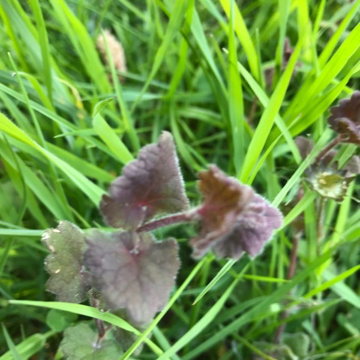

In [ ]:
idx = random.randint(0,len(train_set) - 1)

img, label, is_flower = train_set.get_raw_item(idx)
species = train_set.species[label]
img = img.resize((360,360))
print (f"Class: {label}, {species} Is Flower: {is_flower}")
display(img)


# Data Loading

Pytorch works by sampling from a dataset to train a network. The actual class that does this sampling is usually a DataLoader. Often you don't need to code this yourself, you simply pass various parameters along with the dataset and everything else is handled for you. HEre we set the batch size (number of images we sample and train on at once) alongside other parametes such as 2 workers for loading and preparing the images.

In [ ]:
batch_size = 32
test_batch_size = 32

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

cuda_kwargs = {'num_workers': 2,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(train_set,**train_kwargs)
test_loader = torch.utils.data.DataLoader(valid_set, **test_kwargs)

# Model

The model in pytorch is our actual neural network. Here we're using a convolutiona neural network (CNN) called a ResNet. This is a very popular network, the [paper](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) has 140k citations! The exact reason resnets are popular we won't cover here, but the main thing to understand is we are taking batches of RGB images in the form BxCxHxW e.g. 32x3x224x224, and converting these into predictions of class for each of the 32 images, i.e. 32x32, which is for each image, a list of 32 values representing the likelihood of any particular class. To make this work we have to take our resnet, and alter the default 1000 classes in the last layer to be only 32. In this code model.fc is the last layer.

In [ ]:
cuda = True
num_classes = 32

In [ ]:
model = resnet18(pretrained=True)
model.num_classes=32
channels_in = model.fc.in_features
model.fc = nn.Linear(channels_in, 32)

model = model.to("cuda")

# Testing

If you print the model, torch will show you a summary of all of the layers.

In [ ]:
print(model)

# Training

Now it's time to train the network! If you run this cell, you're actually doing deep learning! We define two functions here, `train` and `test`. Train runs one epoch of training: we sample batches of 32 images and run these through the network until we have used every image in the dataset once. We can then perform more epochs as desired. In this code we are ignoring the flower label, and only predicting class. The key lines are:

`for batch_idx, (data, target, flower) in enumerate(train_loader):`

This iterates over batches in the dataset, with the dataloader handling all the multithreading and preparation for us.

`optimizer.zero_grad()`

This sets the gradients (the directions to move the weights to improve the performance of the network) to zero ready to train on this batch.

`output = model(data)`

`loss = F.cross_entropy(output, target)`

These lines put the batch of images through the model to get a prediction, and then calculate our error / loss by comparing the output to the actual species labels for these 32 images. Intuitively, if the estimate of the network is better, the loss will be lower.

`loss.backward()`

`optimizer.step()`

Finally, we use the loss to calculate new gradients by calling `backward()`. This runs an algorithm called back propagation, which put simply calculates in which direction we could move each weight in the network to make the loss a little smaller next time. We then actually move these weights a little using the `step` function.

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, flower) in enumerate(train_loader):
        data, target = data.to("cuda"), target.to("cuda")
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

The testing code is very similar, except we're running on the testing set, and calculating a percentage accuracy. You don't train on the test set, so we aren't using any loss or optimiser code.

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for (data, target, flower) in test_loader:
            data, target = data.to("cuda"), target.to("cuda")
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
epochs = 3
learning_rate = 0.01
gamma = 0.7
log_interval = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
        scheduler.step()

# Multi-Task

For those of you following up to here, well done! This last bit of code is just a neat extra to give you an idea of some of the extra things you can do with CNNs. Here I am extending our previous design to include two outputs, a 32 class species classification as above, and also a 2 class yes/no flower classification. By using multiple loss functions, we can actually train the network to solve both problems at the same time. Using multiple losses (multi-task learning) is fairly common, as it often lets us provide additional information to a network during training, improving overall performance.

### Multi-task FC module

In [ ]:
class MultiTaskHead(nn.Module):
    def __init__(self, channels_in, num_classes):
        super(MultiTaskHead, self).__init__()

        self.heads = []
        for idx, current_num_classes in enumerate(num_classes):
            s = nn.Sequential(
                nn.Linear(channels_in, 128),
                nn.ReLU(),
                nn.Linear(128, current_num_classes)
            )
            self.add_module(f"Head {idx}", s)
            self.heads.append(s)

    def forward(self, x):
        output = []
        for head in self.heads:
            output.append(head.forward(x))

        return tuple(output)

### Create multi-task head and insert onto the end of Resnet18

In [ ]:
model = resnet18(pretrained=True)
model.num_classes = 32
channels_in = model.fc.in_features

head = MultiTaskHead(channels_in,[32,2])
model.fc = head

model = model.to("cuda")


### Extend training and validation code

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, flower) in enumerate(train_loader):
        data, target = data.to("cuda"), target.to("cuda")
        flower = flower.to("cuda")

        optimizer.zero_grad()
        output = model(data)

        class_output = output[0]
        flower_output = output[1]

        loss = F.cross_entropy(class_output, target)
        loss2 = F.cross_entropy(flower_output, flower)

        final_loss = loss + 0.1 * loss2
        final_loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss2: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss2.item()))

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    flower_loss = 0
    correct = 0
    correct_flower = 0

    with torch.no_grad():
        for (data, target, flower) in test_loader:
            data, target = data.to("cuda"), target.to("cuda")
            flower = flower.to("cuda")

            output = model(data)
            
            class_output = output[0]
            flower_output = output[1]

            test_loss += F.cross_entropy(class_output, target, reduction='sum').item()  # sum up batch loss
            flower_loss += F.cross_entropy(flower_output, flower, reduction='sum').item()

            pred = class_output.argmax(dim=1, keepdim=True)
            pred2 = flower_output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()
            correct_flower += pred2.eq(flower.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Flower Acc  {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        correct_flower, len(test_loader.dataset), 100. * correct_flower / len(test_loader.dataset)))


### Retrain multi-task

In [ ]:
epochs = 6
learning_rate = 0.01
gamma = 0.7
log_interval = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
        scheduler.step()